## User Knowledge Classification Model Project
##### Group 41: Daeun (Kelly) Lee (66638206), Jessie Megan (32533242), Mia (Ziqing) Ling (62106489), Renee Chan (61500666)

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

Attribute Information: <br>
1) STG (The degree of study time for goal object materials) <br>
2) SCG (The degree of repetition number of user for goal object materials) <br>
3) STR (The degree of study time of user for related objects with goal object) <br>
4) LPR (The exam performance of user for related objects with goal object) <br>
5) PEG (The exam performance of user for goal objects) <br>
6) UNS (The knowledge level of user) <br>

In [2]:
user_modeling_dataset = read_excel(path = "data/User_Modeling_Data.xlsx", col_names = TRUE) %>%
    select("STG":"UNS")

# convert user knowledge character into a factor
user_modeling_dataset = user_modeling_dataset %>% mutate(UNS = as_factor(UNS))

set.seed(1)

user_modeling_split = initial_split(user_modeling_dataset, prop = 0.75, strata = UNS)
user_modeling_train = training(user_modeling_split) 
user_modeling_test = testing(user_modeling_split) 

head(user_modeling_train)
# training data will be 75% of the original dataset 
head(user_modeling_test)
# testing data will be 25% of the original dataset

# this dataset is already cleaned and does not need tidying: each row is an observation and each column is a variable with no NA values. 
# we choose to look at the distribution of all predictor variables, analyzing their relationship to user knowledge - done below.

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.08,0.080,0.10,0.24,0.90,High
0.00,0.000,0.50,0.20,0.85,High
0.09,0.300,0.68,0.18,0.85,High
0.08,0.325,0.62,0.94,0.56,High
0.20,0.490,0.60,0.20,0.78,High
0.13,0.390,0.85,0.38,0.77,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.10,0.10,0.43,0.29,0.56,Middle
0.20,0.14,0.35,0.72,0.25,Low
0.18,0.18,0.55,0.30,0.81,High
0.06,0.06,0.51,0.41,0.30,Low
0.10,0.10,0.70,0.15,0.90,High
0.12,0.12,0.75,0.35,0.80,High


In [3]:
UNS_tble <- user_modeling_train |>
                    group_by(UNS) |>
                    summarize(count = n(), percentage = n() / nrow(user_modeling_train) * 100)
UNS_tble


# The first table summarizes the number of observations in each class of UNS (the knowledge level of user).
# There seems to be an imbalance in class very_low, possibly due to the nature of the user population on Electrical DC machines.
# It is assumed that the very_low class has a smaller percentage because individuals had a baseline knowledge of Electrical DC machines, regardless of their scores in each attribute
# discuss implications, drawbacks

UNS,count,percentage
<fct>,<int>,<dbl>
very_low,37,12.33333
High,76,25.33333
Low,96,32.00000
Middle,91,30.33333


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



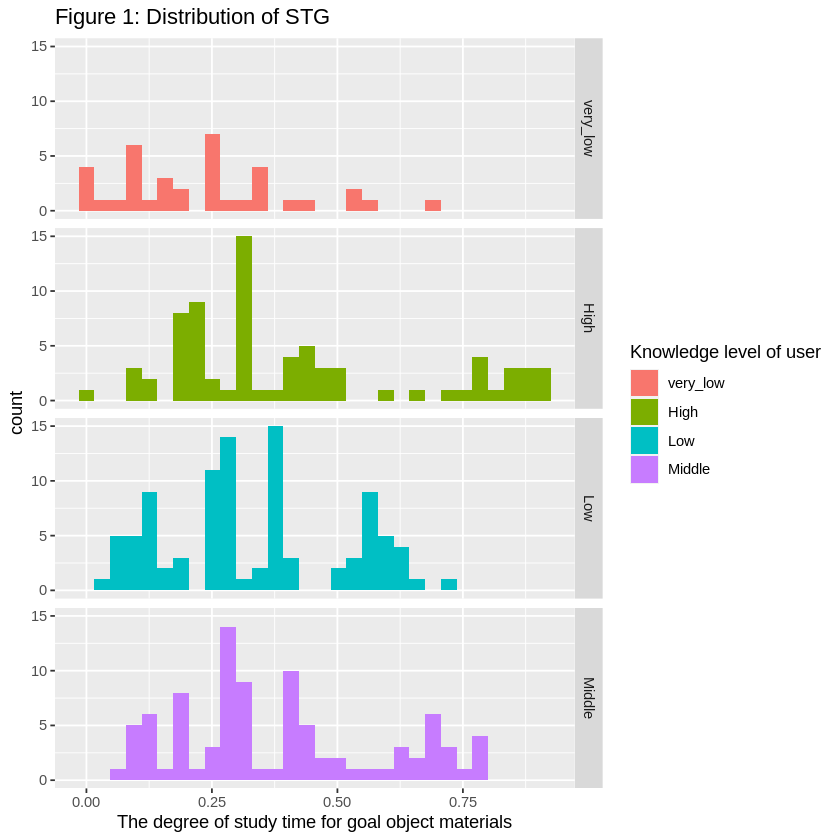

In [4]:
STG_PLOT <- ggplot(user_modeling_train,aes(x = STG, fill = UNS)) +
            geom_histogram() +
            facet_grid(rows = vars(UNS)) +
            labs(x = "The degree of study time for goal object materials", 
                 fill = "Knowledge level of user") +
            ggtitle("Figure 1: Distribution of STG")
STG_PLOT

# This visualization shows that there is not a strong correlation between the degree of study time for goal object materials and a user's knowledge level. 
# STG has a large distribution at low, middle, and high user knowledge levels.
# This variable will be less useful for accurately predicting the knowledge level of a user.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



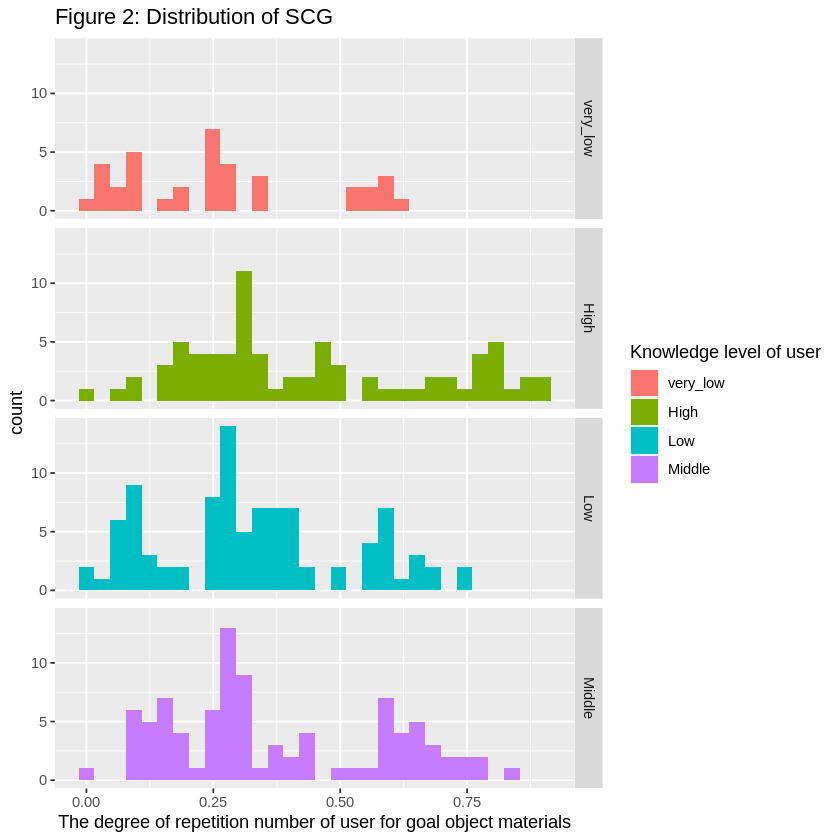

In [5]:
SCG_PLOT <- ggplot(user_modeling_train,aes(x = SCG, fill = UNS)) +
            geom_histogram() +
            facet_grid(rows = vars(UNS)) +
            labs(x = "The degree of repetition number of user for goal object materials", 
                 fill = "Knowledge level of user") +
            ggtitle("Figure 2: Distribution of SCG")
SCG_PLOT

# This visualization shows that there is a weakly positive correlation between the degree of repetition number of user for goal object materials and a user's knowledge level. 
# There is a narrower distribution of SCG between 0 and 0.30 for users with a very_low knowledge level.
# In comparison, the distribution of SCG for users with a high knowledge level is concentrated from 0.20 to 0.9.
# Therefore, SCG can be a useful variable in distinguishing users with a very_low knowledge level to users with a high knowledge level.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



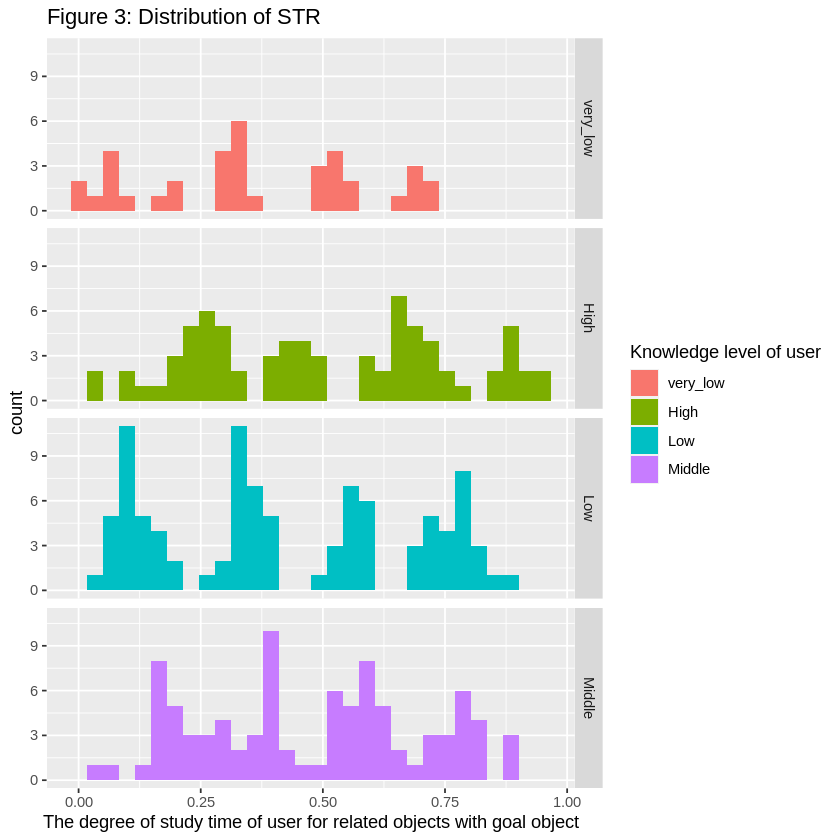

In [13]:
STR_PLOT <- ggplot(user_modeling_train,aes(x = STR, fill = UNS)) +
            geom_histogram() +
            facet_grid(rows = vars(UNS)) +
            labs(x = "The degree of study time of user for related objects with goal object", 
                 fill = "Knowledge level of user") +
            ggtitle("Figure 3: Distribution of STR")
STR_PLOT

# This visualization shows that there is not a strong correlation between the degree of study time of user for related objects with goal object and a user's knowledge level. 
# STR has scattered distributions and peaks at all user knowledge levels.
# This variable will be less useful for accurately predicting the knowledge level of a user.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



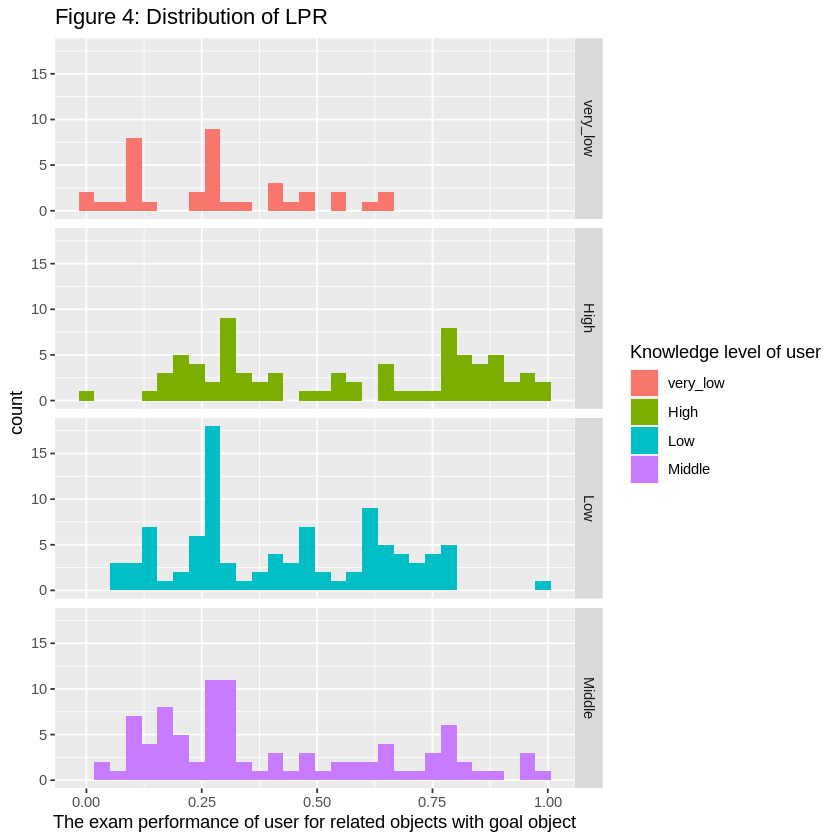

In [7]:
LPR_PLOT <- ggplot(user_modeling_train,aes(x = LPR, fill = UNS)) +
            geom_histogram() +
            facet_grid(rows = vars(UNS)) +
            labs(x = "The exam performance of user for related objects with goal object", 
                 fill = "Knowledge level of user") +
            ggtitle("Figure 4: Distribution of LPR")
LPR_PLOT
# This visualization shows that there is not a strong correlation between the exam performance of user for related objects with goal object and a user's knowledge level. 
# LPR has a large distribution for low, middle, and high knowledge levels. The distribution of LPR for very_low knowledge level of a user is randomly distributed between 0 and 0.70.
# This variable will be less useful for accurately predicting the knowledge level of a user.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



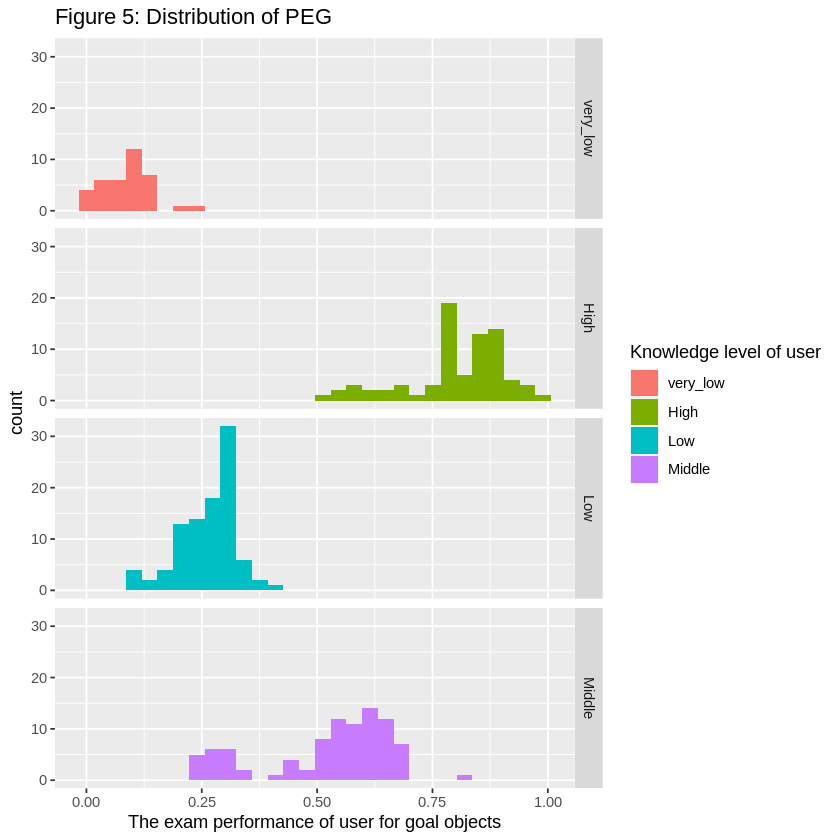

In [8]:
PEG_PLOT <- STG_PLOT <- ggplot(user_modeling_train,aes(x = PEG,fill = UNS)) +
            geom_histogram() +
            facet_grid(rows = vars(UNS)) +
            labs(x = "The exam performance of user for goal objects", 
                 fill = "Knowledge level of user") +
            ggtitle("Figure 5: Distribution of PEG")
PEG_PLOT
# This visualization shows that there is a very strong positive correlation between the exam performance of user for goal objects and a user's knowledge level. 
# There is a narrow distribution of PEG between 0 and 0.25 for users with a very_low knowledge level.
# There is a narrow and skewed distribution of PEG between 0.15 and 0.35 for users with a low knowledge level.
# There is a relatively narrow distribution of PEG between 0.25 and 0.70 for users with a middle knowledge level.
# There is a narrow distribution of PEG between 0.50 and 0.95 for users with a high knowledge level.
# Therefore, PEG can be a useful variable in predicting the knowledge level of a user

In [ ]:
# set the seed 
set.seed (1)

# make a specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification") 

# make a recipe
user_modeling_recipe <- recipe(UNS ~ SCG + PEG, data = user_modeling_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# specify folds 
user_modeling_vfold = vfold_cv(user_modeling_train, v = 10, strata = UNS) 

#specify grid argument 
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# make a workflow, run training data, collect the metrics 
user_modeling_fit <- workflow() %>%
       add_recipe(user_modeling_recipe) %>% 
       add_model(knn_tune) %>%
       tune_grid(resamples = user_modeling_vfold, grid = k_vals) %>% 
        collect_metrics() %>% 
        filter(.metric == "accuracy")
head(user_modeling_fit)

# plot the accuracy vs K 
accuracy_versus_k <- user_modeling_fit %>%
    ggplot(aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Figure 5: K's From 1-30 vs Accuracy")
accuracy_versus_k

In [ ]:
# accuracy at K = 9 on training data
user_modeling_fit %>% 
    filter(neighbors == "9") %>% 
    pull(mean)

# Using K = 9 is the best to use on testing data

In [ ]:
# run classifier on testing data 
test_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>% 
    set_engine("kknn") %>% 
    set_mode("classification") 

test_fit = workflow() %>%
    add_recipe(user_modeling_recipe) %>% 
    add_model(test_spec) %>% 
    fit(data = user_modeling_train)

test_accuracy = test_fit %>% 
    predict(user_modeling_test) %>% 
    bind_cols(user_modeling_test) %>% 
    metrics(truth = UNS, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")
test_accuracy

# find accuracy of K = 9 on testing data
test_accuracy %>% 
    pull(.estimate)

# Using our classifier with K = 9 gives us approximately 80% accuracy when running our testing data, which is close to our training data accuracy.

In [ ]:
# run classifier on a hypothetical user model, proving our thesis: that a higher SCG and PEG would result in a higher user knowledge level.

poor_knowledge_level = tibble(SCG = 0.2, PEG = 0.15) 

test_accuracy_poor = test_fit %>% 
    predict(poor_knowledge_level)
test_accuracy_poor


high_knowledge_level = tibble(SCG = 0.8, PEG = 0.9)

test_accuracy_good = test_fit %>% 
    predict(high_knowledge_level)
test_accuracy_good

### Prediction Model for Knowledge Level of Users: Project Report

Introduction:

<p style='text-align:justify;'> 
Various factors can play a significant role in a student’s knowledge level. Understanding the attributes that contribute to knowledge levels can help improve a student’s academic success. In this project, the following question will be answered: what is the predicted knowledge level of a user given their degree of study time for goal object materials (STG) and the exam performance of the user for goal objects (PEG)?
<br><br>
This project utilizes the User Knowledge Modeling Dataset to predict the knowledge level of a user (UNS) through a classification model created with the k-nearest neighbor algorithm. This dataset examines a group of student’s knowledge pertaining to the subject of Electrical DC machines. The knowledge level can be classified as “Very Low”, “Low” , “Middle”, and “High”. 
</p>

Methods and Results:

We will conduct our data analysis by creating a classification model using the k-nearest neighbors algorithm which can be done by following the steps below:
1) Load the dataset
2) Create a scatterplot
3) Load the dataset
4) Read the csv files into training and testing data set
5) Use group_by and summarize function to find the number of counts for each UNS levels from “very low” to “high”
6) Use summarize function to find the mean of all predictor variables
7) Create STG and PEG histogram plots by stacking them vertically
8) Color-code the UNS

We will visualize the results by creating two sets of histograms, one for STG and the other for PEG. Within each set of histogram, UNS will be the y-axis as we separate each level by color-coding from “very low” to “high.” By stacking the histograms vertically, we can clearly see the distributions of different levels of STG and PEG. We will then be able to compare the relationship between STG and PEG associated with UNS. By using the k-nearest neighbors classification algorithm to predict UNS, we will find the K “nearest” observations from the training data set.

### 4. Expected outcomes and significance

#### a. What do we expect to find?
<p style='text-align:justify;'> 
By developing a classification model to predict students' knowledge level, we expect to understand how relevant the two variables (STG and PEG) are in predicting the knowledge level.
<p>
    
#### b. What impact could such findings have?    
    
<p style='text-align:justify;'> 
Being able to predict students' knowledge level would really help to understand factors that may influence it. Furthermore, this will allow us to understand how to improve their knowledge level and consequently guide them to perform better in class. 
<p>
 
#### c. What future questions could this lead to?   
    
<p style='text-align:justify;'> 
One questions that this classification model may lead to is: 
Are there any other variables that are relevant in predicting students' knowledge level about the subject?
<p>

Discussion:

References: